In [5]:
import numpy as np
import pandas as pd

In [246]:
def create_linear_decay_df(n = 365):
    days = np.arange(0, n + 1)
    score = np.linspace(1, 0, n + 1)
    return pd.DataFrame.from_dict({'days_ago': days, 'score': score})

def create_fixture_matrix():
    matrix = np.zeros((2,2))
    np.fill_diagonal(matrix, 2)
    return matrix

def add_player(existing_matrix, isFixture=True):
    # We want to reshape the matrix/array to include an additional player
    n = existing_matrix.shape[0]
    new_matrix = np.insert(existing_matrix, n, 0, axis=1)
    new_row = np.zeros((1, n + 1))
    if isFixture:
        new_row[0][n] = 2
    return np.append(new_matrix, new_row, axis=0)

def calculate_win_scores(group_results_matrix):
    wins = np.array(group_results_matrix).sum(axis=1)
    losses = np.array(group_results_matrix).sum(axis=0)
    win_scores = 1 + ((wins - losses)) / 2
    return win_scores

def check_player(player, player_arr):
    result = np.where(np.array(player_arr) == player)
    return len(result[0])

In [36]:
results = pd.read_csv('colley.csv')
results.date = pd.to_datetime(results.date)
results

,player_1,player_2,score_1,score_2,date
0,1,2,10,6,2021-01-01
1,1,2,10,3,2021-01-01
2,1,3,5,10,2021-01-01
3,2,3,10,3,2021-01-01
4,3,1,7,10,2021-01-04
5,2,3,4,10,2021-01-04
6,1,4,10,1,2021-01-08
7,4,2,10,7,2021-01-08


We are going to want to loop through the results 1 at a time and update metrics. 

In [4]:
# Create results and fixture matrices
group_results_matrix = np.zeros((2,2))
fixture_matrix = create_fixture_matrix()

# Initialise the players array using row 1
players = []
players.append(results.iloc[0]['player_1'])
players.append(results.iloc[0]['player_2'])

for i in results.index:
    row = results.iloc[i]
    player_1 = row['player_1']
    player_2 = row['player_2']
    
    # Check to see if a new player has played
    if not check_player(player_1, players):
        players.append(player_1)
        fixture_matrix = add_player(fixture_matrix)
        group_results_matrix = add_player(group_results_matrix, False)
        
    if not check_player(player_2, players):
        players.append(player_2)
        fixture_matrix = add_player(fixture_matrix)
        group_results_matrix = add_player(group_results_matrix, False)
    
    player_1_index = np.where(players == player_1)[0][0]    
    player_2_index = np.where(players == player_2)[0][0]
    
    # Calculate winner here and update results matrix
    if row['score_1'] > row['score_2']:
        group_results_matrix[player_1_index][player_2_index] += 1
    else:
        group_results_matrix[player_2_index][player_1_index] += 1
    
    # Increment total games for both players 
    fixture_matrix[player_1_index][player_1_index] += 1
    fixture_matrix[player_2_index][player_2_index] += 1
    
    # Add the fixture to both players overall
    fixture_matrix[player_1_index][player_2_index] -= 1
    fixture_matrix[player_2_index][player_1_index] -= 1
    
    win_scores = calculate_win_scores(group_results_matrix)
    
    print(np.linalg.solve(fixture_matrix, win_scores))
    

[0.625 0.375]
[0.66666667 0.33333333]
[0.54545455 0.27272727 0.68181818]
[0.57142857 0.42857143 0.5       ]
[0.625  0.4375 0.4375]
[0.625 0.375 0.5  ]
[0.67857143 0.40178571 0.52678571 0.39285714]
[0.66666667 0.33333333 0.5        0.5       ]


In [5]:
players

[1, 2, 3, 4]

In [6]:
fixture_matrix

array([[ 7., -2., -2., -1.],
       [-2.,  7., -2., -1.],
       [-2., -2.,  6.,  0.],
       [-1., -1.,  0.,  4.]])

In [7]:
group_results_matrix

array([[0., 2., 1., 1.],
       [0., 0., 1., 0.],
       [1., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [8]:
wins = np.array(group_results_matrix).sum(axis=1)
losses = np.array(group_results_matrix).sum(axis=0)

In [9]:
wins

array([4., 1., 2., 1.])

In [10]:
losses

array([1., 4., 2., 1.])

We would need some way to track the current decay multiplier, but also the version of decay on the previous iteration as you would require the difference between the `i` and `i-1`.

In [14]:
decay_lookup = {1: 0.98, 2:0.96, 3:0.94}

In [16]:
(decay_lookup[1], decay_lookup[3])

(0.98, 0.94)

Something like this could be applied with date comparisons and using 'days ago'. 

In [22]:
decay_lookup = {0: 1}
for i in range(365):
    n = i + 1
    decay_lookup[n] = 1 - n/365

For a given day, the results on that day aren't decayed at all, and then there is a linear decay until a year has passed. At this point results aren't worth anything as they happened too long ago. 

In [31]:
results = pd.read_csv('colley.csv')
results['date'] = pd.to_datetime(results.date)
results['day_diff'] = 0
results.head()

,player_1,player_2,score_1,score_2,date,day_diff
0,1,2,10,6,2021-01-01,0
1,1,2,10,3,2021-01-01,0
2,1,3,5,10,2021-01-01,0
3,2,3,10,3,2021-01-01,0
4,3,1,7,10,2021-01-04,0


In [110]:
# Create results and fixture matrices
group_results_matrix = np.zeros((2,2))
fixture_matrix = create_fixture_matrix()

# Same as above but decay will be applied to these ones 
decayed_results_matrix = group_results_matrix.copy()
decayed_fixture_matrix = group_results_matrix.copy()

# Define the bounds, decayed ranks created each day 
start_date = '2021-01-01'
current_date = '2021-01-14'
date_loop = pd.date_range(start_date, current_date)

# Initialise the players array using row 1
players = []
players.append(results.iloc[0]['player_1'])
players.append(results.iloc[0]['player_2'])

for i in date_loop:
    print(i)
    # For every day that we loop through, the value of the wins reduces by 1/365
    # We maintain a 'true' fixture lookup and a decayed, the former works out the decay values 
    
    # Multiply the existing matrices to decay the fixtures and allow the win_scores to be adjusted
    
    date_mask = results.date <= i
    day_diffs = [j.days for j in (i - results.date)]
    results.day_diff = day_diffs
    
    # Loop through results for the day 

2021-01-01 00:00:00
2021-01-02 00:00:00
2021-01-03 00:00:00
2021-01-04 00:00:00
2021-01-05 00:00:00
2021-01-06 00:00:00
2021-01-07 00:00:00
2021-01-08 00:00:00
2021-01-09 00:00:00
2021-01-10 00:00:00
2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00


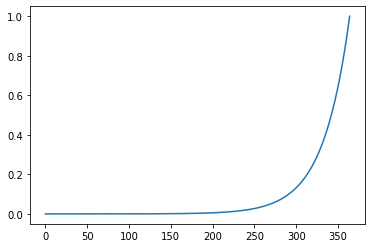

In [107]:
plt.plot(np.geomspace(0.00001, 1, 365))

In [102]:
np.log(0.001)

-6.907755278982137

In [149]:
# Create results and fixture matrices
group_results_matrix = np.zeros((2,2))
fixture_matrix = create_fixture_matrix()

# Same as above but decay will be applied to these ones 
decayed_results_matrix = group_results_matrix.copy()
decayed_fixture_matrix = fixture_matrix.copy()

# Initialise the players array using row 1
players = []
players.append(results.iloc[0]['player_1'])
players.append(results.iloc[0]['player_2'])

for i in results.index:
    row = results.iloc[i]
    player_1 = row['player_1']
    player_2 = row['player_2']
    
    # Check to see if a new player has played
    if not check_player(player_1, players):
        players.append(player_1)
        fixture_matrix = add_player(fixture_matrix)
        decayed_fixture_matrix = add_player(decayed_fixture_matrix)
        group_results_matrix = add_player(group_results_matrix, False)
        decayed_results_matrix = add_player(decayed_results_matrix, False)
        
    if not check_player(player_2, players):
        players.append(player_2)
        fixture_matrix = add_player(fixture_matrix)
        decayed_fixture_matrix = add_player(decayed_fixture_matrix)
        group_results_matrix = add_player(group_results_matrix, False)
        decayed_results_matrix = add_player(decayed_results_matrix, False)
    
    # Calculate the decay to remove
    round_decay_matrix = fixture_matrix.copy()
    
    # We don't want to decay the +2 constant that is part of Laplace's correction
    np.fill_diagonal(round_decay_matrix, (np.diag(round_decay_matrix) - 2))
    round_decay_matrix = round_decay_matrix * 1/365
    decayed_fixture_matrix = decayed_fixture_matrix - round_decay_matrix

    round_results_decay = group_results_matrix.copy()
    round_results_decay = round_results_decay * 1/365
    decayed_results_matrix = decayed_results_matrix - round_results_decay
    
    player_1_index = np.where(players == player_1)[0][0]    
    player_2_index = np.where(players == player_2)[0][0]
    
    # Calculate winner here and update results matrix
    if row['score_1'] > row['score_2']:
        group_results_matrix[player_1_index][player_2_index] += 1
        decayed_results_matrix[player_1_index][player_2_index] += 1
    else:
        group_results_matrix[player_2_index][player_1_index] += 1
        decayed_results_matrix[player_2_index][player_1_index] += 1
    
    # Increment total games for both players 
    fixture_matrix[player_1_index][player_1_index] += 1
    decayed_fixture_matrix[player_1_index][player_1_index] += 1
    fixture_matrix[player_2_index][player_2_index] += 1
    decayed_fixture_matrix[player_2_index][player_2_index] += 1
    
    # Add the fixture to both players overall
    fixture_matrix[player_1_index][player_2_index] -= 1
    decayed_fixture_matrix[player_1_index][player_2_index] -= 1
    fixture_matrix[player_2_index][player_1_index] -= 1
    decayed_fixture_matrix[player_2_index][player_1_index] -= 1
    
    
    win_scores = calculate_win_scores(group_results_matrix)
    decayed_win_scores = calculate_win_scores(decayed_results_matrix)
    
    print(i)
    print(np.linalg.solve(fixture_matrix, win_scores))
    print(np.linalg.solve(decayed_fixture_matrix, decayed_win_scores))

    

0
[0.625 0.375]
[0.625 0.375]
1
[0.66666667 0.33333333]
[0.66659049 0.33340951]
2
[0.54545455 0.27272727 0.68181818]
[0.54519915 0.2730678  0.68173305]
3
[0.57142857 0.42857143 0.5       ]
[0.57099568 0.42931737 0.49968695]
4
[0.625  0.4375 0.4375]
[0.62471944 0.43822755 0.43705301]
5
[0.625 0.375 0.5  ]
[0.62474105 0.37534462 0.49991433]
6
[0.67857143 0.40178571 0.52678571 0.39285714]
[0.67840986 0.4021289  0.52665795 0.39280329]
7
[0.66666667 0.33333333 0.5        0.5       ]
[0.6665916  0.33336077 0.49983103 0.5002166 ]
8
[0.68181818 0.31818182 0.5        0.5       ]
[0.68183069 0.31813712 0.49982187 0.50021033]


In [156]:
# Create results and fixture matrices
group_results_matrix = np.zeros((2,2))
fixture_matrix = create_fixture_matrix()

# Same as above but decay will be applied to these ones 
decayed_results_matrix = group_results_matrix.copy()
decayed_fixture_matrix = fixture_matrix.copy()

# Define the bounds, decayed ranks created each day 
start_date = '2021-01-01'
current_date = '2022-02-01'
date_loop = pd.date_range(start_date, current_date)

# Initialise the players array using row 1
players = []
players.append(results.iloc[0]['player_1'])
players.append(results.iloc[0]['player_2'])

for i in date_loop:
    day_results = results[results.date == i].copy()    
    
    for j in day_results.index:
        row = results.iloc[j]
        player_1 = row['player_1']
        player_2 = row['player_2']
    
        # Check to see if a new player has played
        if not check_player(player_1, players):
            players.append(player_1)
            fixture_matrix = add_player(fixture_matrix)
            decayed_fixture_matrix = add_player(decayed_fixture_matrix)
            group_results_matrix = add_player(group_results_matrix, False)
            decayed_results_matrix = add_player(decayed_results_matrix, False)

        if not check_player(player_2, players):
            players.append(player_2)
            fixture_matrix = add_player(fixture_matrix)
            decayed_fixture_matrix = add_player(decayed_fixture_matrix)
            group_results_matrix = add_player(group_results_matrix, False)
            decayed_results_matrix = add_player(decayed_results_matrix, False)
    
    # Players have been added, so we can now calculate the decay on the existing fixtures without worrying about shapes 
    # Calculate the decay to remove
    round_decay_matrix = fixture_matrix.copy()
    
    # We don't want to decay the +2 constant that is part of Laplace's correction
    np.fill_diagonal(round_decay_matrix, (np.diag(round_decay_matrix) - 2))
    round_decay_matrix = round_decay_matrix * 1/365
    decayed_fixture_matrix = decayed_fixture_matrix - round_decay_matrix

    round_results_decay = group_results_matrix.copy()
    round_results_decay = round_results_decay * 1/365
    decayed_results_matrix = decayed_results_matrix - round_results_decay
    
    
    for j in day_results.index:
        row = results.iloc[j]
        player_1 = row['player_1']
        player_2 = row['player_2']
        
        player_1_index = np.where(players == player_1)[0][0]    
        player_2_index = np.where(players == player_2)[0][0]

        # Calculate winner here and update results matrix
        if row['score_1'] > row['score_2']:
            group_results_matrix[player_1_index][player_2_index] += 1
            decayed_results_matrix[player_1_index][player_2_index] += 1
        else:
            group_results_matrix[player_2_index][player_1_index] += 1
            decayed_results_matrix[player_2_index][player_1_index] += 1

        # Increment total games for both players (inc. decayed as these value are 1 for the day)
        fixture_matrix[player_1_index][player_1_index] += 1
        decayed_fixture_matrix[player_1_index][player_1_index] += 1
        fixture_matrix[player_2_index][player_2_index] += 1
        decayed_fixture_matrix[player_2_index][player_2_index] += 1

        # Add the fixture to both players overall
        fixture_matrix[player_1_index][player_2_index] -= 1
        decayed_fixture_matrix[player_1_index][player_2_index] -= 1
        fixture_matrix[player_2_index][player_1_index] -= 1
        decayed_fixture_matrix[player_2_index][player_1_index] -= 1
    
    
    win_scores = calculate_win_scores(group_results_matrix)
    decayed_win_scores = calculate_win_scores(decayed_results_matrix)
    
    if i > pd.to_datetime('2022-01-01'):
        print(i)
        print(np.linalg.solve(fixture_matrix, win_scores))
        print(np.linalg.solve(decayed_fixture_matrix, decayed_win_scores))

    

2022-01-02 00:00:00
[0.68181818 0.31818182 0.5        0.5       ]
[0.50937082 0.49062918 0.5        0.5       ]
2022-01-03 00:00:00
[0.68181818 0.31818182 0.5        0.5       ]
[0.50677507 0.49322493 0.5        0.5       ]
2022-01-04 00:00:00
[0.68181818 0.31818182 0.5        0.5       ]
[0.50411523 0.49588477 0.5        0.5       ]
2022-01-05 00:00:00
[0.68181818 0.31818182 0.5        0.5       ]
[0.50138889 0.49861111 0.5        0.5       ]
2022-01-06 00:00:00
[0.68181818 0.31818182 0.5        0.5       ]
[0.49859353 0.50140647 0.5        0.5       ]
2022-01-07 00:00:00
[0.68181818 0.31818182 0.5        0.5       ]
[0.4957265 0.5042735 0.5       0.5      ]
2022-01-08 00:00:00
[0.68181818 0.31818182 0.5        0.5       ]
[0.49278499 0.50721501 0.5        0.5       ]
2022-01-09 00:00:00
[0.68181818 0.31818182 0.5        0.5       ]
[0.48976608 0.51023392 0.5        0.5       ]
2022-01-10 00:00:00
[0.68181818 0.31818182 0.5        0.5       ]
[0.48666667 0.51333333 0.5        0.5     

We can incrementally add the records, and then update the existing 'running' data frame, rather than run a subset of the complete for each date. What way we are reducing the creation of objects, but a join will still be required to create a match_value that will then be used to calculate the fixture matrix and results matrix. 

Which way is quicker? 
1. Loop through the fixtures and update numpy matrices 
    a. Loop through days, select out the new fixtures and insert, then recalculate the win_value by joining into lookup or logic update. 
2. Invert and then pivot out via a pandas.DataFrame (as per the original method)

In [219]:
decay_df = create_linear_decay_df(180)
decay_df.head()

,days_ago,score
0,0,1.000000
1,1,0.994444
2,2,0.988889
3,3,0.983333
4,4,0.977778


In [255]:
results = pd.read_csv('colley.csv')
results['date'] = pd.to_datetime(results.date)
results['days_ago'] = 0
results['score'] = 1.0
results.head()

,player_1,player_2,score_1,score_2,date,days_ago,score
0,1,2,10,6,2021-01-01,0,1.0
1,2,3,10,7,2021-01-01,0,1.0
2,3,1,10,5,2021-01-01,0,1.0
3,1,2,6,10,2021-02-02,0,1.0
4,2,3,10,4,2021-02-02,0,1.0


In [256]:
# Create results and fixture matrices
group_results_matrix = np.zeros((2,2))
fixture_matrix = create_fixture_matrix()

# Same as above but decay will be applied to these ones 
decayed_results_matrix = group_results_matrix.copy()
decayed_fixture_matrix = fixture_matrix.copy()

# Define the bounds, decayed ranks created each day 
start_date = '2021-01-01'
current_date = '2022-01-01'
date_loop = pd.date_range(start_date, current_date)

# Initialise the players array using row 1
players = []
players.append(results.iloc[0]['player_1'])
players.append(results.iloc[0]['player_2'])

# Create a data frame that builds with time
realtime_results = results[results.date == '19900101'].copy() 
x = []

for i in date_loop:
    # Increment the days_ago field
    realtime_results['days_ago'] += 1
    
    # Copy the new results and append to existing 
    day_results = results[results.date == i].copy()  
    realtime_results = realtime_results.append(day_results)
    
    # Update the score value 
    final = realtime_results.merge(decay_df, on='days_ago', how='left')
    realtime_results['score'] = final['score_y'].fillna(final['score_x'])
    
    # Create a blank set of matrices for this iteration
    group_results_matrix = np.zeros((2,2))
    fixture_matrix = create_fixture_matrix()
    players = []
    players.append(realtime_results.iloc[0]['player_1'])
    players.append(realtime_results.iloc[0]['player_2'])
    
    for i in realtime_results.index:
        row = realtime_results.iloc[i]
        player_1 = row['player_1']
        player_2 = row['player_2']
        score = row['score']

        # Check to see if a new player has played
        if not check_player(player_1, players):
            players.append(player_1)
            fixture_matrix = add_player(fixture_matrix)
            group_results_matrix = add_player(group_results_matrix, False)
        
        if not check_player(player_2, players):
            players.append(player_2)
            fixture_matrix = add_player(fixture_matrix)
            group_results_matrix = add_player(group_results_matrix, False)

        player_1_index = np.where(players == player_1)[0][0]    
        player_2_index = np.where(players == player_2)[0][0]

        # Calculate winner here and update results matrix
        if row['score_1'] > row['score_2']:
            group_results_matrix[player_1_index][player_2_index] += score
        else:
            group_results_matrix[player_2_index][player_1_index] += score

        # Increment total games for both players 
        fixture_matrix[player_1_index][player_1_index] += score
        fixture_matrix[player_2_index][player_2_index] += score

        # Add the fixture to both players overall
        fixture_matrix[player_1_index][player_2_index] -= score
        fixture_matrix[player_2_index][player_1_index] -= score

    #print(realtime_results)
    #print(group_results_matrix)
    #print(fixture_matrix)
        
    win_scores = calculate_win_scores(group_results_matrix)
    #print(win_scores)
    rankings = np.linalg.solve(fixture_matrix, win_scores)
    x.append(rankings.tolist())
    #print(rankings)
    #print('-----------------')
    #print('-----------------')
    
#print(realtime_results)

In [257]:
len(x)

366

In [258]:
length = max(map(len, x))
y = np.array([xi+[np.nan]*(length-len(xi)) for xi in x])
y

array([[0.5, 0.5, 0.5, nan],
       [0.5, 0.5, 0.5, nan],
       [0.5, 0.5, 0.5, nan],
       ...,
       [0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5]])

In [264]:
np.stack(y)

array([[0.5, 0.5, 0.5, nan],
       [0.5, 0.5, 0.5, nan],
       [0.5, 0.5, 0.5, nan],
       ...,
       [0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5]])

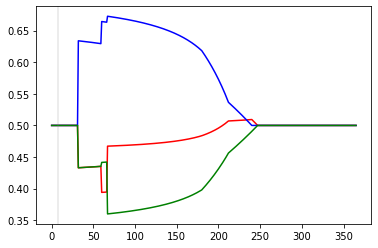

In [241]:
import matplotlib.pyplot as plt

plt.plot(np.stack(y)[:, 0], c='red')
plt.plot(np.stack(y)[:, 1], c='blue')
plt.plot(np.stack(y)[:, 2], c='green')
plt.axvline(7, alpha=0.2, c='gray')
#plt.plot(np.stack(y)[:, 3], c='yellow')
plt.show()

In [242]:
group_results_matrix

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [243]:
fixture_matrix

array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

In [244]:
win_scores

array([1., 1., 1.])

In [245]:
sum(win_scores)

3.0